# Lab 5.1: Radar Design Revisited

In [1]:
%matplotlib widget
import rad.css as css
import rad.air as air
import rad.example as ex
import rad.quiz as qz
from rad.const import c, k
from rad.radar import to_db, from_db, deg2rad, rad2deg
from math import sqrt, sin, asin, cos, acos, tan, atan2, pi, log, log10
css.add_custom_css()

**Reminders**: 

- Hit the *<font color="DarkBlue">Run All</font>* button <img width="18px" src="img/run_all_icon.png"> button above before continuing
- Useful formulae and definitions are available in [Reference](Reference.ipynb)

In our final lab, we will do two things to exercise our knowledge up to this point:

- Review the fundamentals with a series of quizzes
- Design a radar system to track air traffic

Let us begin by testing ourselves on the core ideas covered up to this point.

## Cumulative Review

***

### Question 1

For a dish radar with diameter $D = 4~\mathrm{m}$ operating at frequency $f = 10~\mathrm{GHz}$:

**(a)** What is the transmit wavelength, $\lambda$?

In [2]:
qz.quiz_5_1_1a()

In [3]:
# Scratch space

**(b)** What is the minimum beamwidth, $\Delta \theta$?

In [4]:
qz.quiz_5_1_1b()

In [5]:
# Scratch space

**(c)** What is the maximum transmit gain, $G_t(\theta)$?

In [6]:
qz.quiz_5_1_1c()

In [7]:
# Scratch space

***

***

### Question 2

**(a)** What is the received energy, $\mathcal{E}_r$ , for a radar system with:

- Transmit and receive area $A_r = A_t = 10~\mathrm{m^2}$
- Transmit frequency, $f = 2~\mathrm{GHz}$
- Transmit energy, $\mathcal{E}_t = 10~\mathrm{J}$

when it observes a target in the center of the beam (i.e., maximum gain) at range $r = 200~\mathrm{km}$ with radar cross section $-5~\mathrm{dBsm}$?

In [8]:
qz.quiz_5_1_2a()

In [9]:
# Scratch space

**(b)** If the system noise temperature is $T_s = 500~^\circ K$, what is the signal-to-noise ratio?

In [10]:
qz.quiz_5_1_2b()

In [11]:
# Scratch space

***

***

### Question 3

**(a)** What is the duty cycle, $d$ , for a radar that uses a pulsewidth of $t_p = 100~\mu\mathrm{s}$ and a pulse repetition frequency of $f_{rep} = 2~\mathrm{kHz}$?

In [12]:
qz.quiz_5_1_3a()

In [13]:
# Scratch space

**(b)** If a pulse achieves a signal-to-noise ratio of $5~\mathrm{dB}$ on a target, how many pulses of coherent integration are needed to achieve an SNR of at least $17~\mathrm{dB}$? 

In [14]:
qz.quiz_5_1_3b()

In [15]:
# Scratch space

***

***

### Question 4

**(a)** What does the minimum bandwidth, $B$ , of the transmit signal required to be able to discern two targets $\delta r = 1.5~\mathrm{m}$ apart?

In [16]:
qz.quiz_5_1_4a()

In [17]:
# Scratch space

**(b)** What is the horizontal cross-range resolution, $\delta r_\perp$ , at range $r = 90~\mathrm{km}$ of a rectangular radar system with aperture width $w = 5.2 ~\mathrm{m}$ and transmit frequency $f = 5~\mathrm{GHz}$?

In [18]:
qz.quiz_5_1_4b()

In [19]:
# Scratch space

**(c)** What is the maximum magnitude of relative range rate, $|\dot{r}|$ , that can be unambiguously measured by a radar that sends a set of pulses with pulse repetition frequency, $f_{rep} = 700~\mathrm{Hz}$, and transmit frequency $f = 3~\mathrm{GHz}$?

In [20]:
qz.quiz_5_1_4c()

In [21]:
# Scratch space

***

## Radar Design for Air Target Tracking

Now that we have proven our mastery of the key concepts, let us try and build a radar system and use it to track airplanes. In this section of the lab, we will be bringing together the design of transmitters, receivers, antennas, and detectors. 

Here is the problem at hand: the local airport has to perform maintenance on its air traffic surveillance systems for the next few months and needs us to help fill the gap. They are giving us a budget to build a rotating dish radar system that will allow us to manually track up to $6$ airplanes in a $10~\mathrm{km}$ radius and figure out their flight path. Each airplane has a unique radar cross section value that we can use to identify it, ranging from $\sigma  = -5~\mathrm{dBsm}$ to $\sigma = 15~\mathrm{dBsm}$.

### Flight Paths

In the figure below, we can see the possible flight path from the perspective of our radar screen. There are a total of $6$ paths, and it is possible for an airplane to travel either direction on each path. Note that these paths will be randomly drawn every time you restart the notebook with the *<font color="DarkBlue">Run All</font>* button <img width="18px" src="img/run_all_icon.png">; if they look too difficult or easy to discern, try rerunning the notebook.

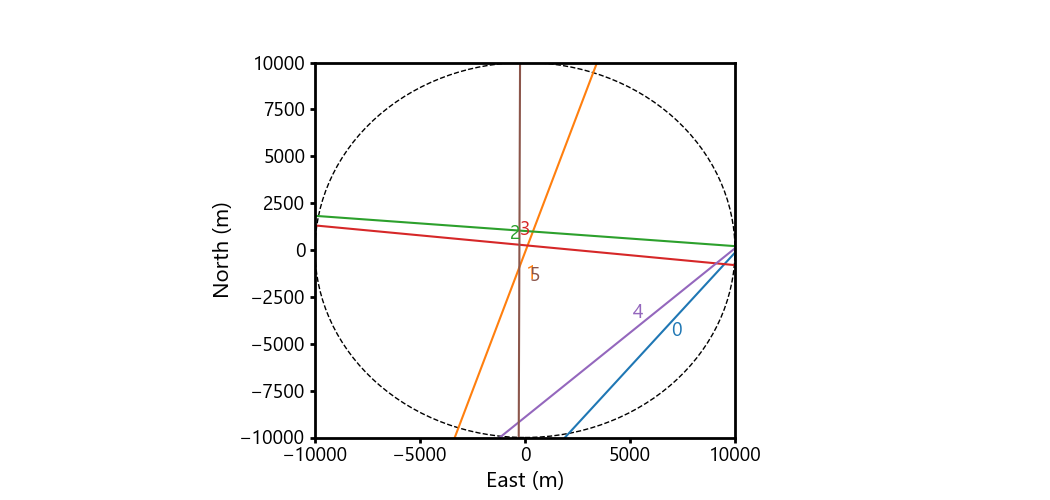

In [22]:
routes, targets = ex.ex_5_1_1()

### Radar Design with a Budget

Now it is time to design our radar system that will be helping us watch air traffic. We have been given a budget of $\$50~\mathrm{k}$, and our local radar manufacturer has given us the following price breakdowns for a rotating dish radar system:



| Hardware                 | Price                                    |
|--------------------------|------------------------------------------|
| Dish Radius              | $\$10000/\mathrm{m}$                     |
| Scan Rate                | $\$500/\mathrm{scans}/\mathrm{min}$      |
| Transmit Bandwidth       | $\$100/\mathrm{MHz}$                     |
| Transmit Energy          | $\$20/\mathrm{mJ}$                       |
| Transmit Frequency       | $\$10/\mathrm{MHz}$                      |
| Noise Temperature        | $\$50/^\circ K$ below $1500 ^\circ K$    |

| Processing               | Price                                    |
|--------------------------|------------------------------------------|
| Coherent Integration     | $\$100/\mathrm{Pulse}$                   |
| Noncoherent Integration  | $\$40/\mathrm{Pulse}$                    |

To see how the different choices influence price, use the following interactive example.

In [23]:
ex.ex_5_1_2()

Now, let us set some objectives for our radar design based on the application at hand. First, we can try designing for sensitivity to get a rough handle on what we will need. On the sliders below, choose the most stressing case we would expect to see in terms of *<font color="DarkBlue">Target Range</font>* and *<font color="DarkBlue">Target RCS</font>*. Then, set the *<font color="DarkBlue">Objective SNR</font>* to a desired design point to ensure that we will be able to confidently detect the target. Then, try to design the radar and stay under $\$50~\mathrm{k}$.

In [24]:
ex.ex_5_1_2b()

### Test Range

Now that we have a feel for achieving the desired sensitivity, we can go out to the simulated test range to refine our design to make tracking as easy as possible. Here, we will manually track one known airplane, while being able to change our radar parameters. The test flight pattern is below:

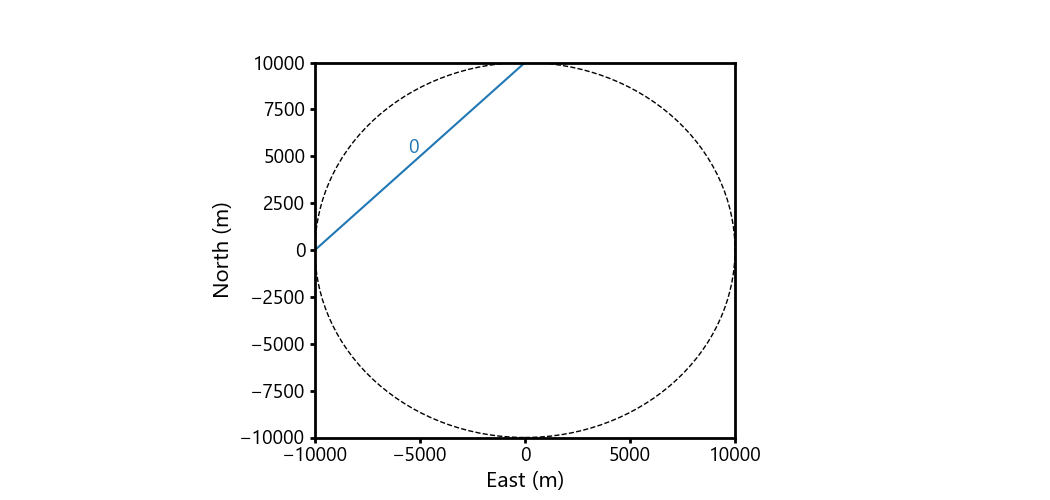

In [25]:
test_tgt = ex.ex_5_1_3a()

The interactive example of the test radar is below. Make sure to dial in your chosen design from above and note that you can use the *<font color="DarkBlue">Reset</font>* button to return the target to its starting position. Some things to consider:

- **Resolution**: For routes that are very close to each other, range and angle resolution will be important to discern separate targets. Recall what radar design parameters affect these values. SNR values when two targets are unresolved will not be reliable. 
- **Scan Rate**: Faster scan rates allow for more chances to observe targets and characterize their motion.

Now, iterate upon your original design to prepare for manual tracking of aircraft.

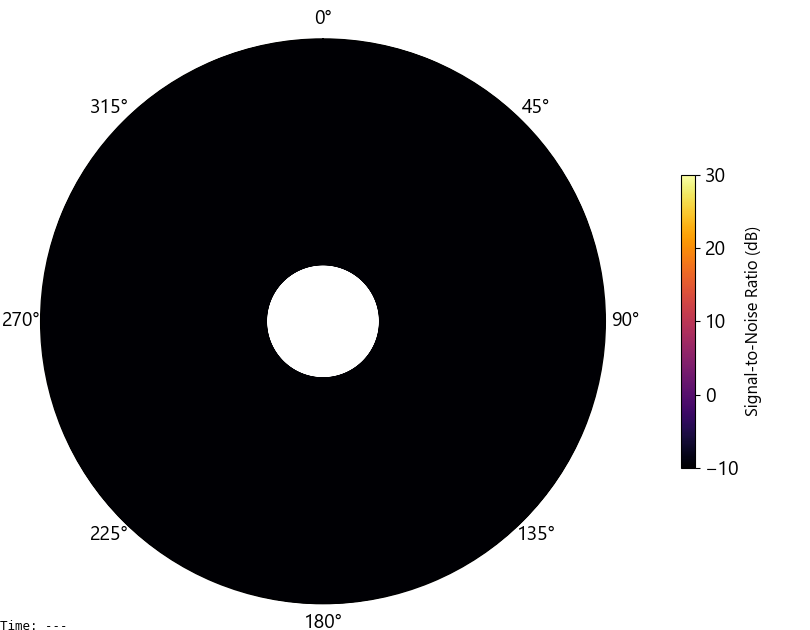

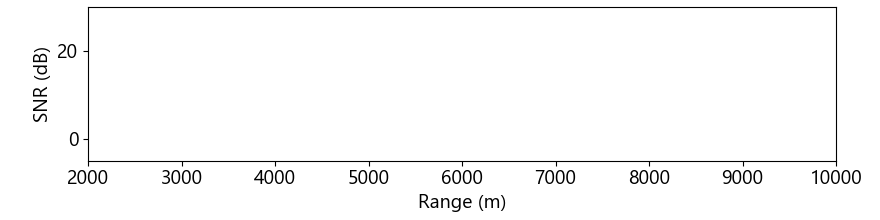

In [26]:
ex.ex_5_1_3b(test_tgt)

Now it is time to lock in our design, build our radar, and track some airplanes.

### Flight Test

In the interactive example below, set your design decisions you made at the simulated test range. Progress through each radar scan, and, as you identify a plane and its trajectory, log it below. Note that you will only get one pass for each time you run the notebook, so proceed through the scans carefully. Here are a few tips:

- Make sure to use the *<font color="DarkBlue">Pulse Azimuth</font>* slider to estimate the peak SNR of a target.

- It will save time to derive a reference SNR for your chosen system, i.e., calculate the reference SNR, $\mathrm{SNR}_0$ , for a target with RCS $\sigma_0 = 0~\mathrm{dBsm}$ at a range of $r_0 = 5~\mathrm{km}$ and use the RCS estimator formula (also in the [Reference](Reference.ipynb)):

$$
\hat{\sigma} = \frac{\mathrm{SNR}}{\mathrm{SNR}_0} \cdot \left(\frac{\hat{r}}{r_0}\right)^4 \cdot {\sigma_0}
$$

- Remember to account for integration in your reference SNR calculation

For reference, here are the expected flight paths:

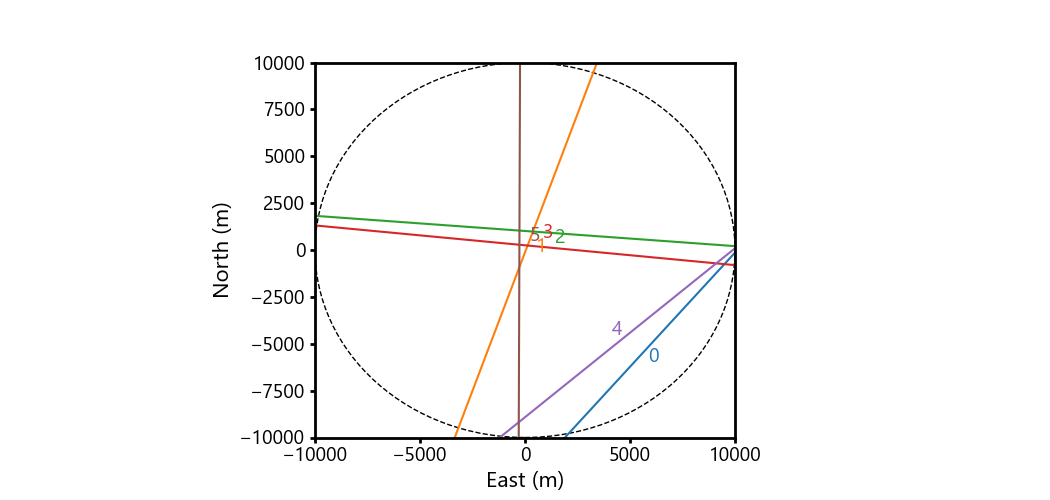

In [27]:
ex.ex_5_1_4a(routes, targets)

Here is the radar display. Good luck!

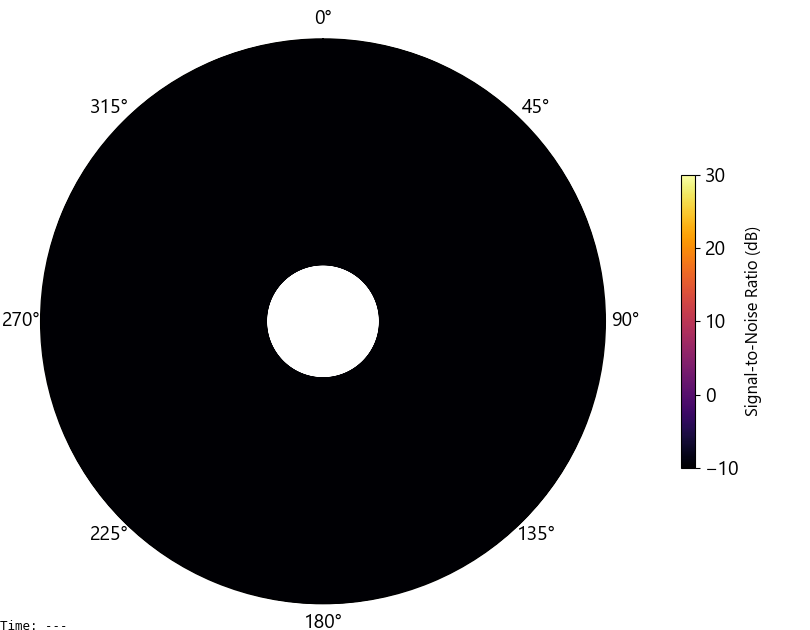

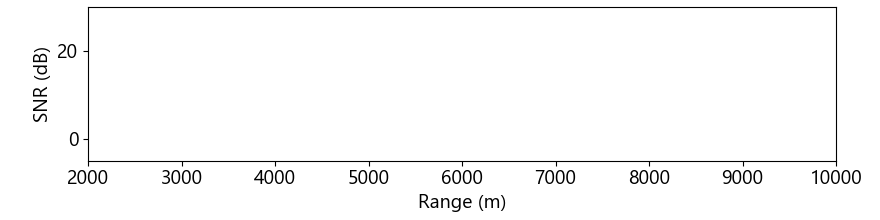

In [28]:
ex.ex_5_1_4b(routes, targets)

### Air Traffic Log

Place your estimated route numbers below:

In [29]:
qz.quiz_5_1_5(targets)

In [30]:
# Scratch space

Feel free to restart the notebook using the *<font color="DarkBlue">Run All</font>* button <img width="18px" src="img/run_all_icon.png"> and try again. If you think you identified the right aircraft but had issues with the estimated routes, double-check your reference SNR calculation.

## Summary

In our final lab, we focused on two activities to exercise our knowledge up to this point:

- Review the fundamentals with a series of quizzes
- Design a radar system to track air traffic

Designing a radar system with a notional budget emphasizes the different ways that resolution and signal-to-noise ratio can be improved.

## Footnotes

n/a

## References

n/a